### Imports and configuration

In [1]:
# setup variables

import os
import json
import tqdm
from s2orc.config import CURRENT_VERSION

# jsonlines https://jsonlines.readthedocs.io/en/latest/#api
import jsonlines
import gzip
import numpy as np
import matplotlib.pyplot as plt
import hiplot # <3

LOCAL_S2ORC_DIR = 's2orc-data'

psychology_paper_dir = os.path.join(LOCAL_S2ORC_DIR, CURRENT_VERSION, 'psychology')
psychology_paper_suffix = 'psych.text.jsonl'

links_dir = os.path.join(LOCAL_S2ORC_DIR, CURRENT_VERSION, 'psych_links')
links_suffix = 'psych.text.link.jsonl'

## let's do it! <3

In [2]:
import pprint

start = 0
span = 1 # all: 1700

links_files = sorted(os.listdir(links_dir), key=lambda f: int(f.split('.')[0]))[start:(start+span)]
for link_file in tqdm.tqdm(links_files):
    with gzip.open(os.path.join(links_dir, link_file), 'rb') as f_in:
        links = list(jsonlines.Reader(f_in))
        for link in links:
            pp = pprint.PrettyPrinter(indent=1)
            pp.pprint(link['citing_paper']['metadata'])
            pp.pprint(link['citation_context'])
            pp.pprint(link['cited_paper']['metadata'])

100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

{'abstract': None,
 'acl_id': None,
 'arxiv_id': None,
 'authors': [{'first': 'Anagha', 'last': 'Aery', 'middle': [], 'suffix': ''},
             {'first': 'Julie', 'last': 'Hodges', 'middle': [], 'suffix': ''},
             {'first': 'Jamin', 'last': 'Day', 'middle': ['J.'], 'suffix': ''}],
 'doi': '10.2991/uipsur-17.2018.50',
 'journal': 'Proceedings of the Universitas Indonesia International Psychology '
            'Symposium for Undergraduate Research (UIPSUR 2017)',
 'pmc_id': None,
 'pubmed_id': None,
 'title': 'The Effect of School-Based Stepping Stones Triple P on Child and '
          'Parent Outcomes',
 'venue': 'Proceedings of the Universitas Indonesia International Psychology '
          'Symposium for Undergraduate Research (UIPSUR 2017)',
 'year': '2018'}
{'cite_end': 345,
 'cite_start': 297,
 'cite_str': 'Roberts, Mazzucchelli, Studman, & Sanders, 2006;',
 'cited_paper_id': '2019870',
 'context_string': 'Roberts, Mazzucchelli, Studman, & Sanders, 2006;',
 'paper_id': '1

## Get corpus into memory

In [3]:
import pprint

start = 0
span = 1700 # all: 1700

links = []

links_files = sorted(os.listdir(links_dir), key=lambda f: int(f.split('.')[0]))[start:(start+span)]
for link_file in tqdm.tqdm(links_files):
    with gzip.open(os.path.join(links_dir, link_file), 'rb') as f_in:
        batch_links = list(jsonlines.Reader(f_in))
        links.extend(batch_links)

np.random.seed(2134234)
links = np.array(links)
np.random.shuffle(links)

100%|██████████| 1500/1500 [00:50<00:00, 29.90it/s]


In [4]:

n_train_links = int(0.5 * len(links))
n_validation_links = int(0.2 * len(links))
n_test_links = len(links) - n_train_links - n_validation_links
train_links = links[:n_train_links]
validation_links = links[n_train_links:n_train_links + n_validation_links]
test_links = links[-n_test_links:]

## Do stuff

  0%|          | 0/1 [00:00<?, ?it/s]




--- PAPER --- 
 Spatial separation between targets constrains maintenance of attention on multiple objects.


context:  with such suppressive interactions, the presence of nearby stimuli can impair performance on a variety of tasks (Cave and Zimmerman, 1997; Bahcall and Kowler, 1999; Mounts, 2000; Kristjánsson et al., 2002; McCarley et al., 2004; Alvarez and Franconeri, 2007; Shim et al., 2008; Hilimire et al., 2009; Franconeri et al., 2010; Chan and Hayward, 2012) . Topdown attention, however, serves to isolate the attended items from their surround (Moran and Desimone, 1985; Luck et al., 1997; Recanzone et al., 1997; Kastner et



similarities: 




(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


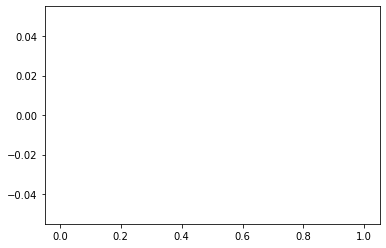

In [10]:
from syntok.segmenter import split
from syntok.tokenizer import Tokenizer
import json
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings, StackedEmbeddings
from flair.data import Sentence
import numpy as np
import tqdm
import sys

glove_embedding = DocumentPoolEmbeddings([WordEmbeddings('glove')])

f_out = sys.stdout

n = 1
for link in tqdm.tqdm(train_links[:n]):
    context = link['citation_context']
    citing_paper = link['citing_paper']
    cited_paper = link['cited_paper']
    
    # find the adequate context pair
    glove_similarities = []
    citing_string = ''.join([context['pre_context'], context['context_string'], context['post_context']])
    s = Sentence(citing_string, use_tokenizer=True)
    glove_embedding.embed(s)
    glove_citation_embedding = s.embedding.detach()

    for paper_part, text_chunks in cited_paper['grobid_parse'].items():
        if text_chunks is not None:
            for text_chunk in text_chunks:
                if isinstance(text_chunk, dict):
                    text = text_chunk.get('text')
                    tokenized_sents = list(split(Tokenizer().tokenize(text)))
                    sents = [' '.join(str(token) for token in sent) for sent in tokenized_sents]

                    sentences = [s for s in [Sentence(sent, use_tokenizer=True) for sent in sents] if len(s.tokens) > 0]
                    embeddings = glove_embedding.embed(sentences)
                    for s in sentences:
                        e1 = s.embedding.detach()
                        e2 = glove_citation_embedding
                        sim = np.dot(e1, e2) / (np.sqrt(np.dot(e1, e1)) * np.sqrt(np.dot(e2, e2)))
                        glove_similarities.append((sim, s.to_original_text()))

            print('\n\n\n--- PAPER ---', '\n', cited_paper['metadata']['title'], file=f_out, end='\n')
            print('\n\ncontext: ', citing_string, file=f_out, end='\n\n')
            print('\n\nsimilarities: ', file=f_out, end='\n\n')
            print(*sorted(glove_similarities, key=lambda x: x[0], reverse=True)[:20], file=f_out, sep='\n\n')
            just_sim = [sim for sim, text in glove_similarities]
            plt.hist(just_sim, bins=np.linspace(0, 1, 20))
#             print('FLAIR')
#             print(*sorted(flair_similarities, key=lambda x: x[0], reverse=True)[:10], sep='\n\n')    